**Image Classification in Machine Learning**

Goal: Create a basic image classifier to distinguish images of dogs vs images of cats.

This model was created using the following guide:
https://keras.io/examples/vision/image_classification_from_scratch/


**Setup**

In [1]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers

**Load the data: "Cat vs Dogs dataset"**



In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   109M      0  0:00:07  0:00:07 --:--:--  109M


In [3]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls
!ls PetImages

replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
 kagglecatsanddogs_3367a.zip  'MSR-LA - 3467.docx'  'readme[1].txt'
 model.png		       PetImages	     sample_data
Cat  Dog


In [4]:
#The code below is used to filter out corrupted images 
#Following the guide, I am going to remove badly-encoded images from the dataset
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


**Generating the Dataset**

In [5]:
image_size = (80, 80)
batch_size = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


**Visualizing the Data**

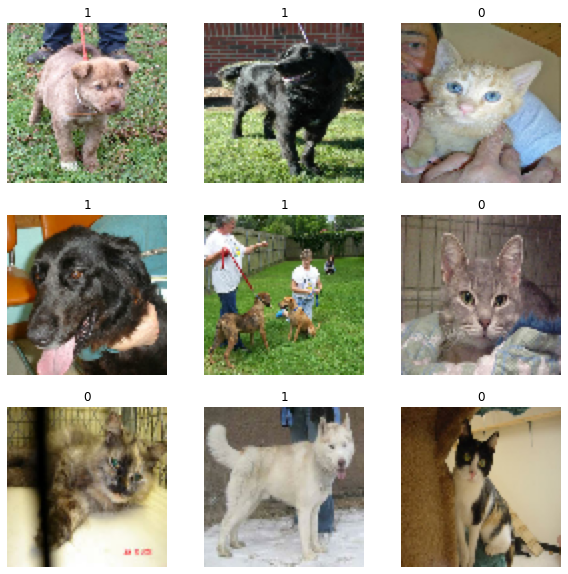

In [6]:
#The code below displays I sample of the training dataset
# Note: 
#     - label 1 are pictures of dogs
#     - label 2 are pictures of cats
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

**Data Augmentation**

The dataset is not very large; by applying transformations to the training image, sample diversity is artifically introduced. 

Data augmentation helps expose the model to different aspects of the trianing data and slows down overfitting.



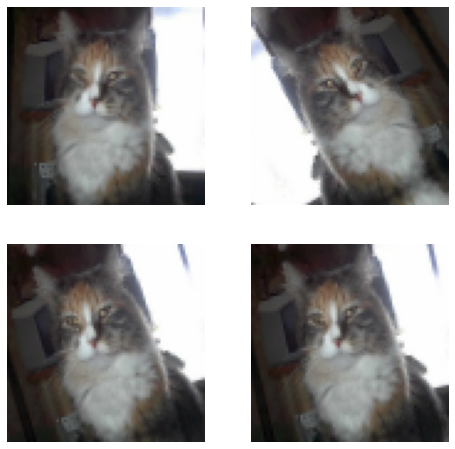

In [11]:
#transforms the data by slightly rotating and flipping some of the dataset 
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

#visualize a sample of the augmented data
plt.figure(figsize=(8, 8))
for images, _ in train_ds.take(1):
    for i in range(4):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


**Preprocess and Standardize the Data**

In [8]:
# Apply the augmented data to the dataset
# Data augmentation will occur on CPU and be buffered before going into the model
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

**Building a Model**

The model is going to have three convolutional layer, two dense hidden layers, two dropout layer, and an output layer.

In [9]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 80, 80, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 80, 80, 3)    0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 40, 40, 32)   896         rescaling[0][0]                  
______________________________________________________________________________________________

In [10]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/10
293/293 [==============================] - 977s 3s/step - loss: 0.6645 - accuracy: 0.6280 - val_loss: 0.7817 - val_accuracy: 0.4957
Epoch 2/10
293/293 [==============================] - 973s 3s/step - loss: 0.4761 - accuracy: 0.7710 - val_loss: 0.5945 - val_accuracy: 0.6856
Epoch 3/10
293/293 [==============================] - 971s 3s/step - loss: 0.3935 - accuracy: 0.8183 - val_loss: 0.7428 - val_accuracy: 0.6924
Epoch 4/10
293/293 [==============================] - 965s 3s/step - loss: 0.3530 - accuracy: 0.8423 - val_loss: 0.4510 - val_accuracy: 0.8225
Epoch 5/10
293/293 [==============================] - 968s 3s/step - loss: 0.3223 - accuracy: 0.8559 - val_loss: 0.4690 - val_accuracy: 0.7977
Epoch 6/10
293/293 [==============================] - 968s 3s/step - loss: 0.2967 - accuracy: 0.8718 - val_loss: 0.3023 - val_accuracy: 0.8669
Epoch 7/10
293/293 [==============================] - 962s 3s/step - loss: 0.2707 - accuracy: 0.8837 - val_loss: 0.4754 - val_accuracy: 0.8078

In [12]:
# Run inference on new data
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 97.64 percent cat and 2.36 percent dog.
